In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import scipy.io as sio
from keras.layers import Conv3D, AveragePooling3D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#dataPath = '../data/butter_feature_tensor_with_labels.mat'
#dataPath = '../data/csp_features_full_with_full_labels.csv'
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images_3dcnn_norm.mat'
savePath = '../Results/CNN_3D_our/'

experiment = 'HALA_Full'

filename = savePath+'CNN_3D_results_'+experiment+'.mat'
plot_title = 'HA vs LA Classification- Full'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['full_feat_img']
print("features shape:", features.shape)
labels = np.squeeze(matContent['full_hala_labels'])
labels[labels < 0] = 0
features = np.swapaxes(features,2,4)
features = np.swapaxes(features,2,3)
#labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

features shape: (14800, 5, 3, 32, 32)


In [3]:
labels_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [4]:
class_num

2

In [5]:
features.shape

(14800, 5, 32, 32, 3)

In [6]:
np.unique(labels)

array([0, 1])

In [7]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv3D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(features.shape[1], features.shape[2], features.shape[3], features.shape[4]), trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv3D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv3D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [8]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.001, 0.01, 0.1]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
#feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
#scaler = StandardScaler()
#scaler.fit(features)
#scaleFeatures = scaler.transform(features)
#scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
grid_result = grid.fit(features,labels_categorical)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
tf.keras.backend.clear_session()
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

Performing Gridsearch
Best parameters: {'activation': 'tanh', 'dropout_rate': 0.3, 'init_mode': 'he_uniform', 'learn_rate': 0.1, 'optimizer': 'Adam'}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 32, 32, 16)     1312      
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 16, 16, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 16, 16, 32)     13856     
_________________________________________________________________
average_pooling3d_1 (Average (None, 2, 8, 8, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 8, 8, 32)       27680     
_________________________________________________________________
average_pooling3d_2 (Average (None, 1, 4, 4, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

Epoch 5/30
375/375 - 22s - loss: 0.1316 - accuracy: 0.9521 - val_loss: 0.2785 - val_accuracy: 0.9047
Epoch 6/30
375/375 - 22s - loss: 0.1301 - accuracy: 0.9489 - val_loss: 0.2628 - val_accuracy: 0.9039
Epoch 7/30
375/375 - 22s - loss: 0.1270 - accuracy: 0.9512 - val_loss: 0.2507 - val_accuracy: 0.9137
Epoch 8/30
375/375 - 22s - loss: 0.1209 - accuracy: 0.9525 - val_loss: 0.2501 - val_accuracy: 0.9129
Epoch 9/30
375/375 - 22s - loss: 0.1170 - accuracy: 0.9550 - val_loss: 0.2745 - val_accuracy: 0.9182
Epoch 10/30
375/375 - 22s - loss: 0.1174 - accuracy: 0.9560 - val_loss: 0.2547 - val_accuracy: 0.9174
Epoch 11/30
375/375 - 22s - loss: 0.1145 - accuracy: 0.9555 - val_loss: 0.2438 - val_accuracy: 0.9129
Epoch 12/30
375/375 - 22s - loss: 0.1114 - accuracy: 0.9571 - val_loss: 0.2394 - val_accuracy: 0.9167
Epoch 13/30
375/375 - 22s - loss: 0.1081 - accuracy: 0.9585 - val_loss: 0.2643 - val_accuracy: 0.9122
Epoch 14/30
375/375 - 22s - loss: 0.1061 - accuracy: 0.9585 - val_loss: 0.2729 - val_ac

Epoch 1/30
375/375 - 22s - loss: 0.0673 - accuracy: 0.9765 - val_loss: 0.2878 - val_accuracy: 0.9159
Epoch 2/30
375/375 - 22s - loss: 0.0631 - accuracy: 0.9768 - val_loss: 0.2897 - val_accuracy: 0.9249
Epoch 3/30
375/375 - 22s - loss: 0.0644 - accuracy: 0.9761 - val_loss: 0.3040 - val_accuracy: 0.9174
Epoch 4/30
375/375 - 22s - loss: 0.0630 - accuracy: 0.9771 - val_loss: 0.2788 - val_accuracy: 0.9189
Epoch 5/30
375/375 - 22s - loss: 0.0521 - accuracy: 0.9809 - val_loss: 0.2953 - val_accuracy: 0.9227
Epoch 6/30
375/375 - 22s - loss: 0.0590 - accuracy: 0.9791 - val_loss: 0.2887 - val_accuracy: 0.9242
Epoch 7/30
375/375 - 22s - loss: 0.0544 - accuracy: 0.9799 - val_loss: 0.3792 - val_accuracy: 0.8926
Epoch 8/30
375/375 - 22s - loss: 0.0606 - accuracy: 0.9786 - val_loss: 0.3282 - val_accuracy: 0.9189
Epoch 9/30
375/375 - 22s - loss: 0.0534 - accuracy: 0.9807 - val_loss: 0.3048 - val_accuracy: 0.9137
Epoch 10/30
375/375 - 22s - loss: 0.0567 - accuracy: 0.9802 - val_loss: 0.3511 - val_accura

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 32, 32, 16)     1312      
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 16, 16, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 16, 16, 32)     13856     
_________________________________________________________________
average_pooling3d_1 (Average (None, 2, 8, 8, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 8, 8, 32)       27680     
_________________________________________________________________
average_pooling3d_2 (Average (None, 1, 4, 4, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

375/375 - 22s - loss: 0.0364 - accuracy: 0.9878 - val_loss: 0.3851 - val_accuracy: 0.9129
Epoch 13/30
375/375 - 22s - loss: 0.0348 - accuracy: 0.9879 - val_loss: 0.4170 - val_accuracy: 0.9204
Epoch 14/30
375/375 - 22s - loss: 0.0285 - accuracy: 0.9899 - val_loss: 0.3569 - val_accuracy: 0.9219
Epoch 15/30
375/375 - 22s - loss: 0.0348 - accuracy: 0.9880 - val_loss: 0.4239 - val_accuracy: 0.9174
Epoch 16/30
375/375 - 22s - loss: 0.0393 - accuracy: 0.9862 - val_loss: 0.3649 - val_accuracy: 0.9212
Epoch 17/30
375/375 - 22s - loss: 0.0421 - accuracy: 0.9847 - val_loss: 0.3432 - val_accuracy: 0.9212
Epoch 18/30
375/375 - 22s - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.3662 - val_accuracy: 0.9129
Epoch 19/30
375/375 - 22s - loss: 0.0331 - accuracy: 0.9887 - val_loss: 0.3737 - val_accuracy: 0.9219
Epoch 20/30
375/375 - 22s - loss: 0.0337 - accuracy: 0.9871 - val_loss: 0.4369 - val_accuracy: 0.9219
Epoch 21/30
375/375 - 22s - loss: 0.0340 - accuracy: 0.9873 - val_loss: 0.3823 - val_accuracy:

Epoch 1/30
375/375 - 22s - loss: 0.0324 - accuracy: 0.9881 - val_loss: 0.3918 - val_accuracy: 0.9182
Epoch 2/30
375/375 - 22s - loss: 0.0377 - accuracy: 0.9860 - val_loss: 0.3681 - val_accuracy: 0.9287
Epoch 3/30
375/375 - 22s - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.3496 - val_accuracy: 0.9227
Epoch 4/30
375/375 - 22s - loss: 0.0323 - accuracy: 0.9883 - val_loss: 0.4080 - val_accuracy: 0.9249
Epoch 5/30
375/375 - 22s - loss: 0.0356 - accuracy: 0.9865 - val_loss: 0.3712 - val_accuracy: 0.9287
Epoch 6/30
375/375 - 22s - loss: 0.0281 - accuracy: 0.9897 - val_loss: 0.3822 - val_accuracy: 0.9242
Epoch 7/30
375/375 - 22s - loss: 0.0294 - accuracy: 0.9905 - val_loss: 0.3618 - val_accuracy: 0.9227
Epoch 8/30
375/375 - 22s - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.3876 - val_accuracy: 0.9272
Epoch 9/30
375/375 - 22s - loss: 0.0318 - accuracy: 0.9887 - val_loss: 0.4415 - val_accuracy: 0.9212
Epoch 10/30
375/375 - 22s - loss: 0.0359 - accuracy: 0.9874 - val_loss: 0.3726 - val_accura

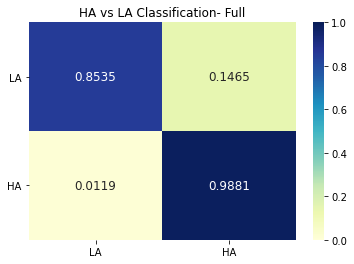

Mean and std of F1 MACRO is 0.9350 +- 0.0442
Mean and std of F1 WEIGHTED is 0.9654 +- 0.0231
Mean and std of accuracy is 0.9662 +- 0.0221


In [9]:
conf_mat = np.zeros((2,2))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

for train, test in kfold.split(features, labels):
  trainingFeatures = features[train,:,:, :]
  testFeatures = features[test,:,:, :]
  train_shape = trainingFeatures.shape
  test_shape = testFeatures.shape
  tf.keras.backend.clear_session()#to clear any previosuly obtiained models
  estimator.summary()
  estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                epochs=epochs, verbose=2, validation_split=0.1)

  predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
  predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
  cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0, 1])
  conf_mat = conf_mat+cm

  precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
  recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
  f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
  f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
  accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
  print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
  print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
  print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
  f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
#fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_yticklabels(['PD', 'NC'], rotation = 0) # for spectral
ax.set_yticklabels(['LA', 'HA'], rotation = 0)
#ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['LA', 'HA'], rotation = 0)
#ax.set_xticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_xticklabels(['PD', 'NC'], rotation = 0) # for spectral

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                      'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs})